In [1]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import xgboost as xgb

import os
import numpy as np
import sys
import tensorflow as tf
import random
import keras
from scipy.interpolate import PchipInterpolator
from statsmodels.stats.stattools import medcouple

SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [2]:
os.chdir("../")
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from Predictions import (
    PredictionExperiment,
    PredictionModel,
    get_info_experiment
)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [20]:
def compute_adjusted_boxplot_bounds(y):
    """
    Compute adjusted boxplot bounds using medcouple (MC) for skewness adjustment.
    """
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    mc = medcouple(y)

    if mc >= 0:
        lower = q1 - 1.5 * np.exp(-4 * mc) * iqr
        upper = q3 + 1.5 * np.exp(3 * mc) * iqr
    else:
        lower = q1 - 1.5 * np.exp(-3 * mc) * iqr
        upper = q3 + 1.5 * np.exp(4 * mc) * iqr

    median = np.median(y)
    return lower, median, upper

def piecewise_linear_phi_2(y, bounds, initial_weight=0.1):
    x1, x2, x3, x4 = tf.unstack(bounds)
    # iqr = (x3-x2)
    # x1, x2, x3, x4, x5, x6, x7 = x1, x2, x2+iqr/4, x2+ iqr/2, x2 + iqr*0.75, x3, x4
    y1, y2, y3, y4 = initial_weight, initial_weight, 1, 1
    return tf.where(
        y <= x1, y1,
        tf.where(
            y <= x2,  y2 + (y2-y1)/(x2-x1)*(y-x2),
            tf.where(
                y <= x3, y3 + (y3-y2)/(x3-x2)*(y-x3),
                tf.where(
                    y <= x4, tf.ones_like(y), tf.ones_like(y)
                    )
                )
            )
        )

def piecewise_linear_phi_np(bounds, initial_weight=0.1):
    x1, x2, x3, x4 = bounds
    # iqr = (x3-x2)
    # x1, x2, x3, x4, x5, x6, x7 = x1, x2, x2+iqr/4, x2+ iqr/2, x2 + iqr*0.75, x3, x4
    y1, y2, y3, y4 = initial_weight, initial_weight, 1, 1
    return lambda y: np.where(
        y <= x1, y1,
        np.where(
            y <= x2,  y2 + (y2-y1)/(x2-x1)*(y-x2),
            np.where(
                y <= x3, y3 + (y3-y2)/(x3-x2)*(y-x3),
                np.where(
                    y <= x4, np.ones_like(y), np.ones_like(y)
                    )
                )
            )
        )

def create_relevance_function(y):
    """
    Create a PCHIP-based relevance function φ(y) using adjusted boxplot bounds.
    """
    lower, median, upper = compute_adjusted_boxplot_bounds(y)
    
    # Extend with actual min/max to smooth edges
    # x = np.array([min(y), lower, median, upper, max(y)])
    x = np.array([lower, median, upper, max(y)])
    # if x[1] < x[0]:
    #     x[1] = (x[0]+ x[2])/2
    relevance = np.array([0, 0, 1.0, 1.0])

    # Ensure strictly increasing x by removing duplicate values
    x_unique, idx = np.unique(x, return_index=True)
    relevance_unique = relevance[idx]
    print(x_unique)
    print(relevance_unique)
    pchip = PchipInterpolator(x_unique, relevance_unique, extrapolate=True)
    return pchip

def read_hws(path, date_format='%Y-%m'):
    data = pd.read_csv(path)
    data["Date"] = pd.to_datetime(data["Date"],format=date_format)
    data.set_index('Date', inplace=True)
    return data


In [18]:
# Re-import necessary packages after reset
import numpy as np

def sera_first_deriv(trues, preds, phi, step=0.001):
    """
    Compute the first derivative (gradient) of the SERA loss.
    """
    th = np.arange(0, 1 + step, step)
    n = len(trues)

    # Compute error contribution over thresholds
    errors = np.array([
        [(preds[i] - trues[i]) if phi[i] >= t else 0.0 for t in th]
        for i in range(n)
    ])

    # Trapezoidal integration
    areas = step * 0.5 * (errors[:, :-1] + errors[:, 1:])
    y_deriv = 2 * np.sum(areas, axis=1)

    return y_deriv

def sera_second_deriv(trues, phi, step=0.001):
    """
    Compute the second derivative (Hessian) of the SERA loss.
    """
    th = np.arange(0, 1 + step, step)
    n = len(trues)

    # Binary mask over thresholds
    errors = np.array([
        [1.0 if phi[i] >= t else 0.0 for t in th]
        for i in range(n)
    ])

    # Trapezoidal integration
    areas = step * 0.5 * (errors[:, :-1] + errors[:, 1:])
    y_deriv = 2 * np.sum(areas, axis=1)

    return y_deriv

def sera_objective(phi_fn, step=0.001):
    def loss(predt: np.ndarray, dtrain: xgb.DMatrix):
        y = dtrain.get_label()
        phi_vals = phi_fn(y)
        grad = sera_first_deriv(y, predt, phi_vals, step=step)
        hess = sera_second_deriv(y, phi_vals, step=step)
        return grad, hess
    return loss


In [5]:
region = "chile"
indices = ["HWN", "HWD", "HWF", "HWM", "HWA"]

hws = read_hws(f"data/local_data/monthly/HWs_chile_central.csv")
scaler = StandardScaler()
hws[indices] = scaler.fit_transform(hws[indices])

In [46]:
hws_index = hws[["HWN"]].to_numpy()
hws_index = hws_index.reshape(hws_index.shape[0])
l, m ,u  = compute_adjusted_boxplot_bounds(hws_index)
bounds = (l, m, u, max(hws_index))
relevance = create_relevance_function(hws_index)
print(bounds)

[-1.67198855 -0.2172401   3.78913747  5.04912742]
[0. 0. 1. 1.]
(-1.6719885526939446, -0.21724009528776392, 3.7891374659690613, 5.04912741648646)


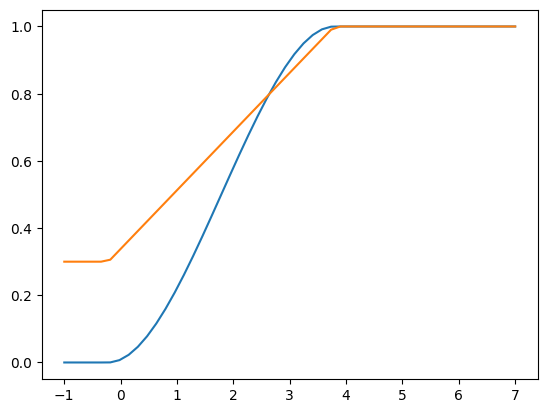

In [47]:
x = np.linspace(-1, 7)
plt.plot(x, relevance(x))
plt.plot(x, piecewise_linear_phi_np(bounds, initial_weight=0.3)(x))

In [48]:
from sklearn.base import BaseEstimator, RegressorMixin

class XGBCustomObjective(BaseEstimator, RegressorMixin):
    """
    Wrapper class to make XGBoost with custom objectives compatible with sklearn.
    This is needed for MultiOutputRegressor.
    """
    def __init__(self, objective_func=None, random_state=42, n_estimators=15, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, **kwargs):
        self.objective_func = objective_func
        self.random_state = random_state
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.kwargs = kwargs
        self.model = None
        
    def fit(self, X, y):
        """Fit the model with custom objective."""
        # Create DMatrix
        dtrain = xgb.DMatrix(X, label=y)
        
        # Set up parameters using your specified values
        params = {
            'max_depth': self.max_depth,
            'eta': self.learning_rate,  # learning_rate
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree,
            'seed': self.random_state,  # random_state
            'disable_default_eval_metric': 1 if self.objective_func else 0
        }
        params.update(self.kwargs)
        
        if self.objective_func:
            # Train with custom objective
            self.model = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=self.n_estimators,
                obj=self.objective_func,
                verbose_eval=False
            )
        else:
            # Train with standard objective
            params['objective'] = 'reg:squarederror'
            del params['disable_default_eval_metric']
            self.model = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=self.n_estimators,
                verbose_eval=False
            )
        
        return self
    
    def predict(self, X):
        """Make predictions."""
        dtest = xgb.DMatrix(X)
        return self.model.predict(dtest)
    
    def get_params(self, deep=True):
        """Get parameters for this estimator (required for sklearn compatibility)."""
        params = {
            'objective_func': self.objective_func,
            'random_state': self.random_state,
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'max_depth': self.max_depth,
            'subsample': self.subsample,
            'colsample_bytree': self.colsample_bytree
        }
        params.update(self.kwargs)
        return params
    
    def set_params(self, **params):
        """Set parameters for this estimator (required for sklearn compatibility)."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                self.kwargs[key] = value
        return self

In [49]:
from sklearn.multioutput import MultiOutputRegressor

In [50]:
custom_model = XGBCustomObjective(
    objective_func=sera_objective(piecewise_linear_phi_np(bounds, initial_weight=0.3)),
    random_state=42,
    n_estimators=15,
    learning_rate=0.1
)
id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
features = data.columns.difference(indices)
len_pred = 5

X = data[features]
y = data[indices]

# Split into training and testing sets
X_train, X_test, y_train, y_test = X[:-len_pred], X[-len_pred:], y[:-len_pred], y[-len_pred:]

# Use MultiOutputRegressor with custom model
multi_custom_model = MultiOutputRegressor(custom_model)
multi_custom_model.fit(X_train, y_train)

y_pred_custom = multi_custom_model.predict(X_test)

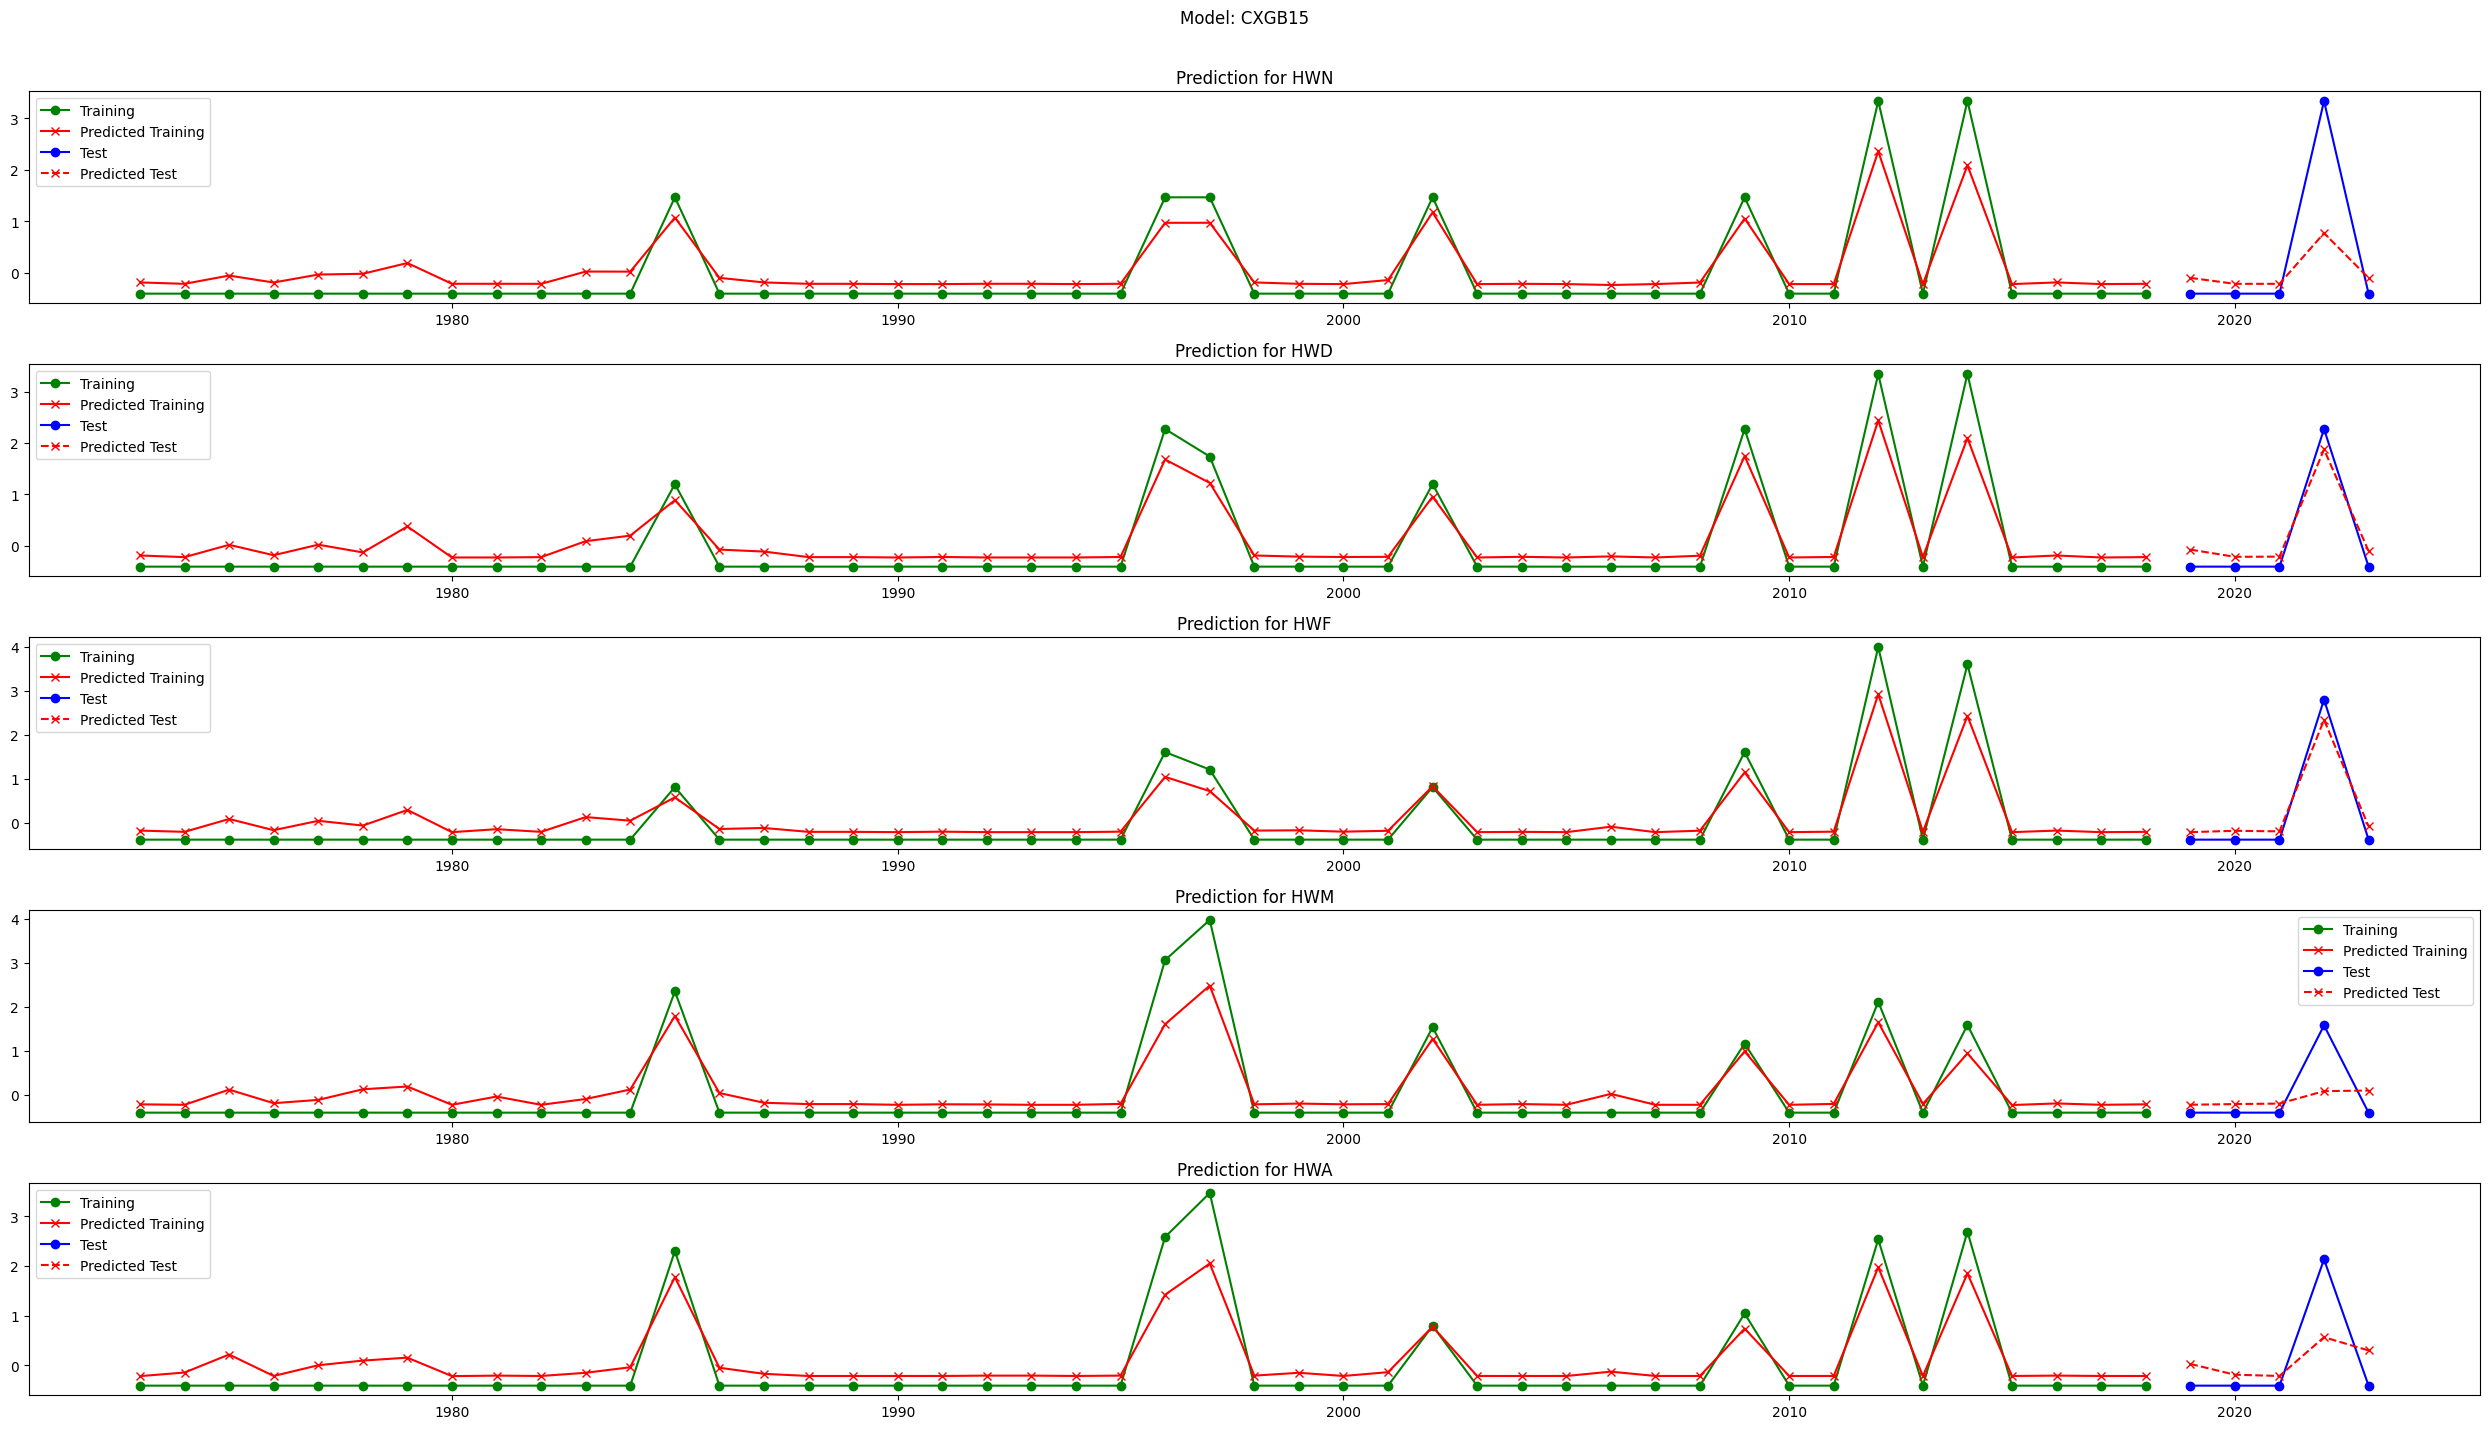

In [51]:
id = "231a6330"
season = 12
data = pd.read_parquet(f"data/locally_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = XGBCustomObjective(
    objective_func=sera_objective(piecewise_linear_phi_np(bounds, initial_weight=0.3)),
    random_state=42,
    n_estimators=15,
    learning_rate=0.1
)

pred = PredictionModel(data, season, indices, model, name_regressor="CXGB15")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

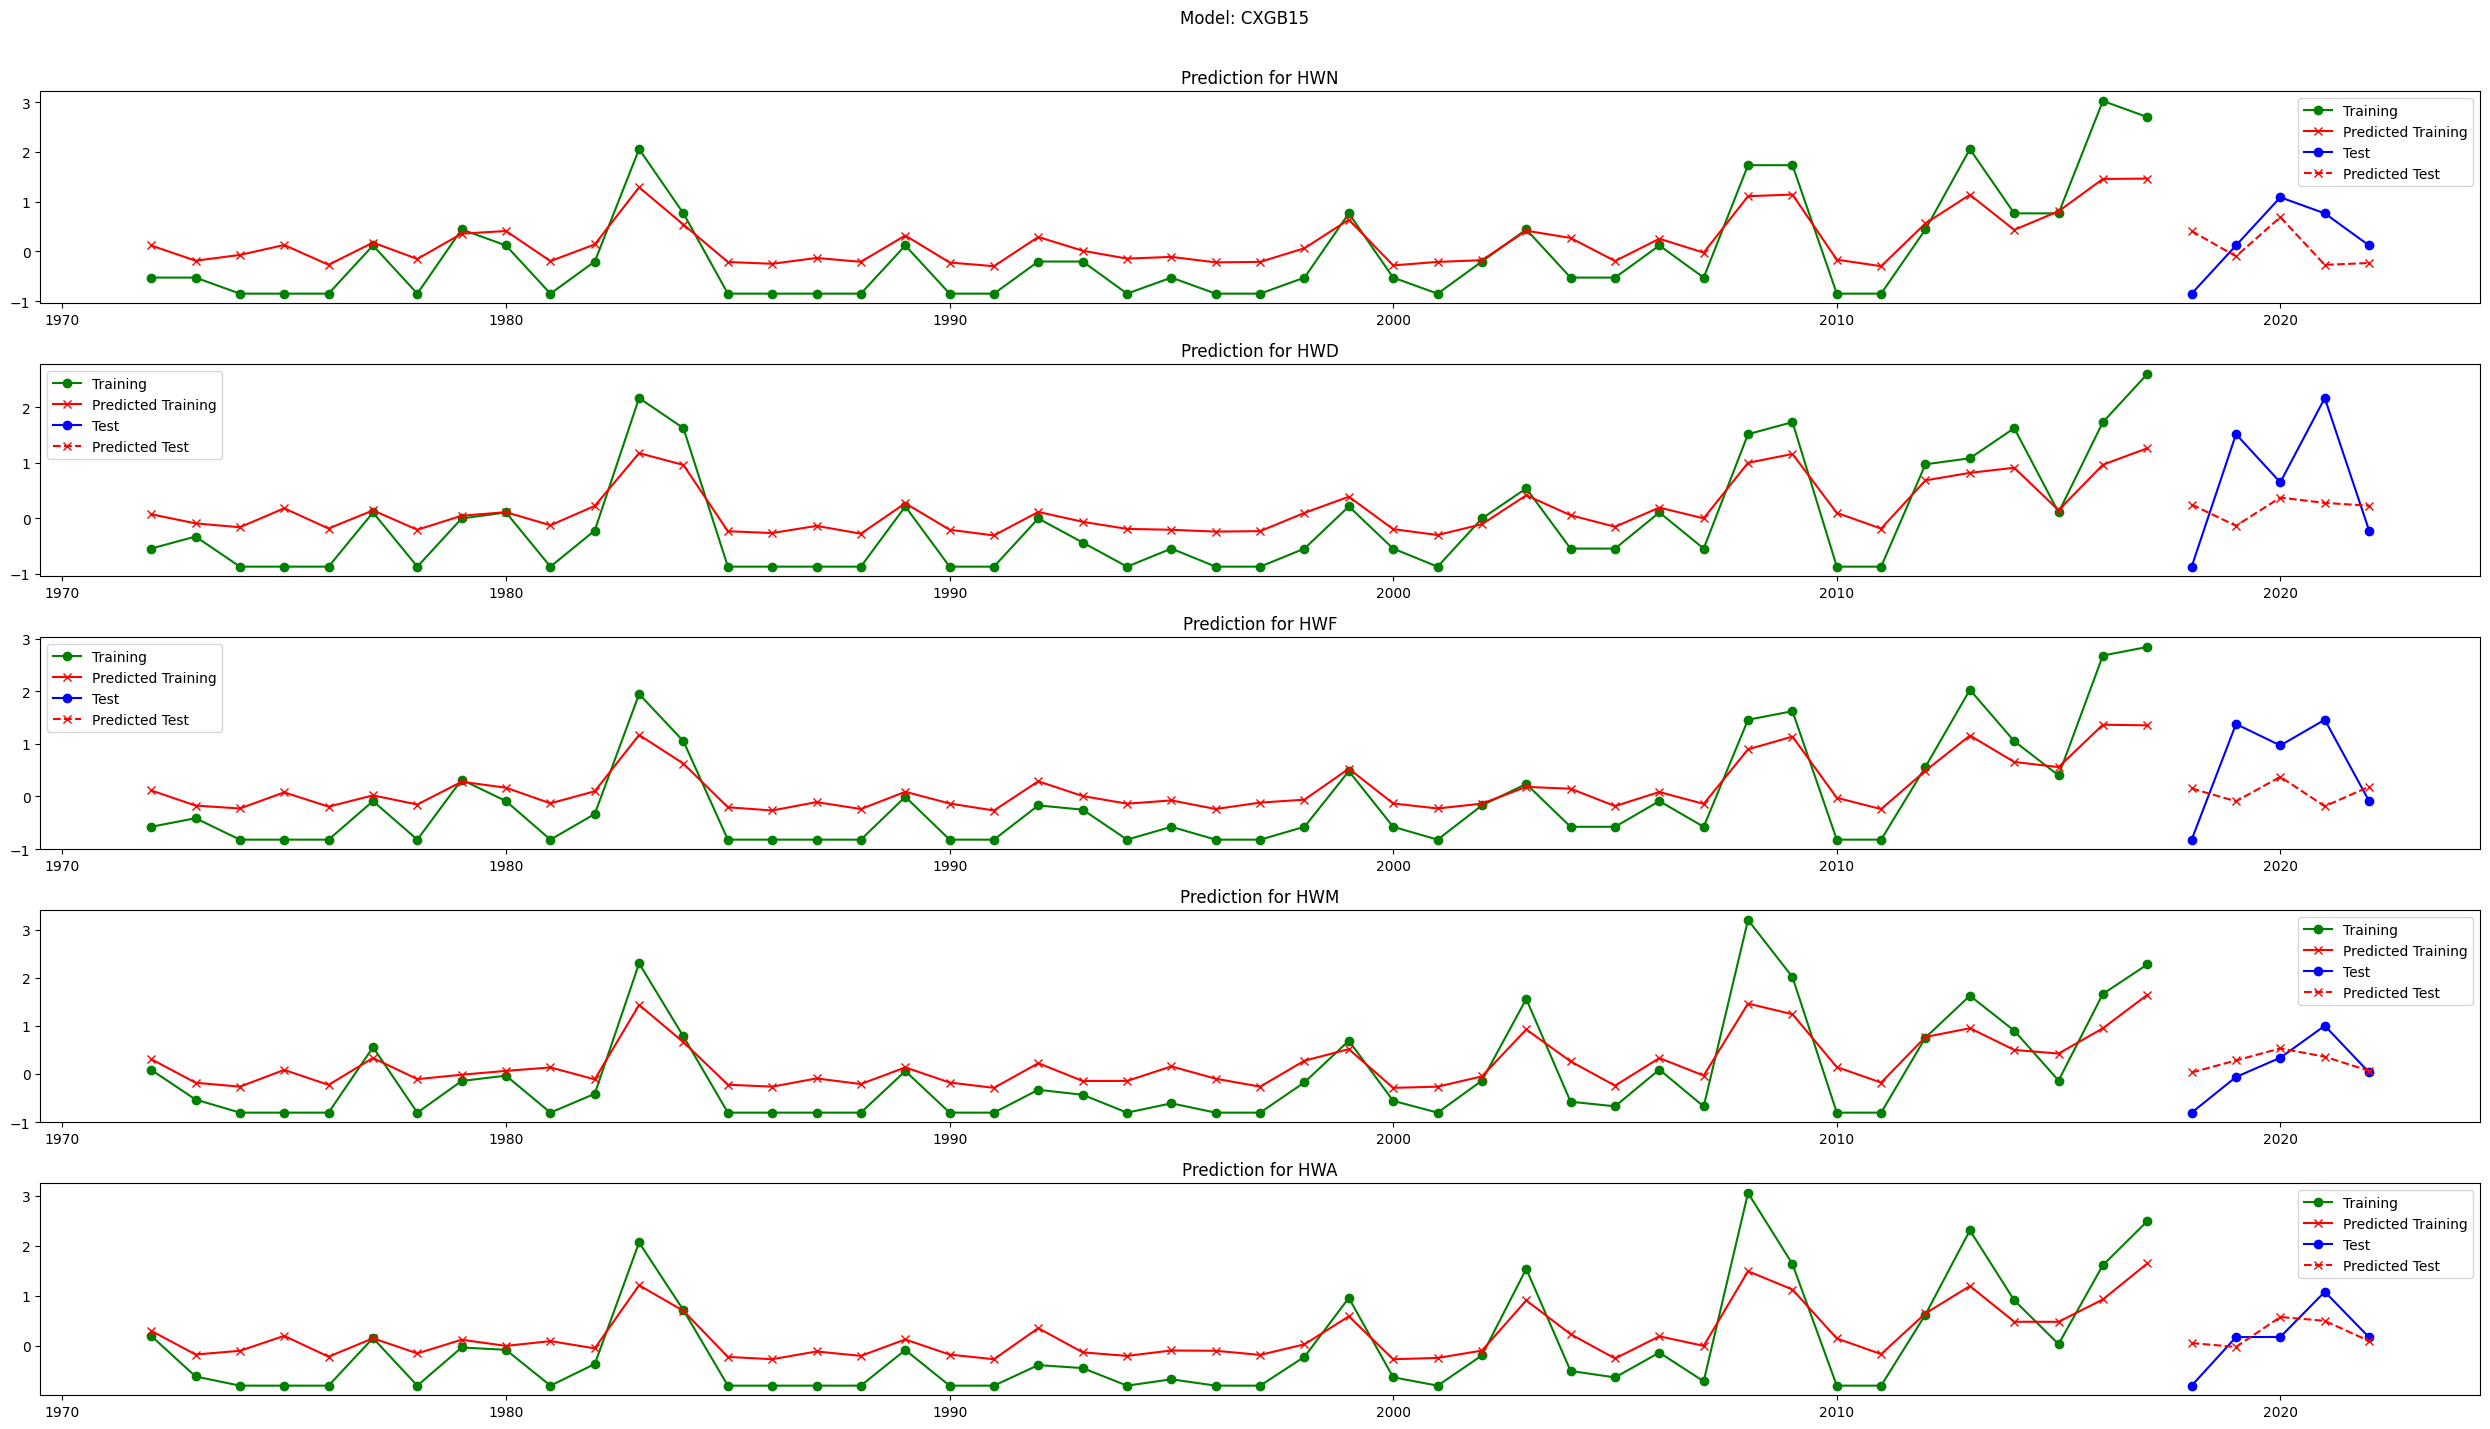

In [58]:
id = "ecf2577f"
season = 1
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = XGBCustomObjective(
    objective_func=sera_objective(piecewise_linear_phi_np(bounds, initial_weight=0.3)),
    random_state=42,
    n_estimators=10,
    learning_rate=0.1
)

pred = PredictionModel(data, season, indices, model, name_regressor="CXGB15")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)

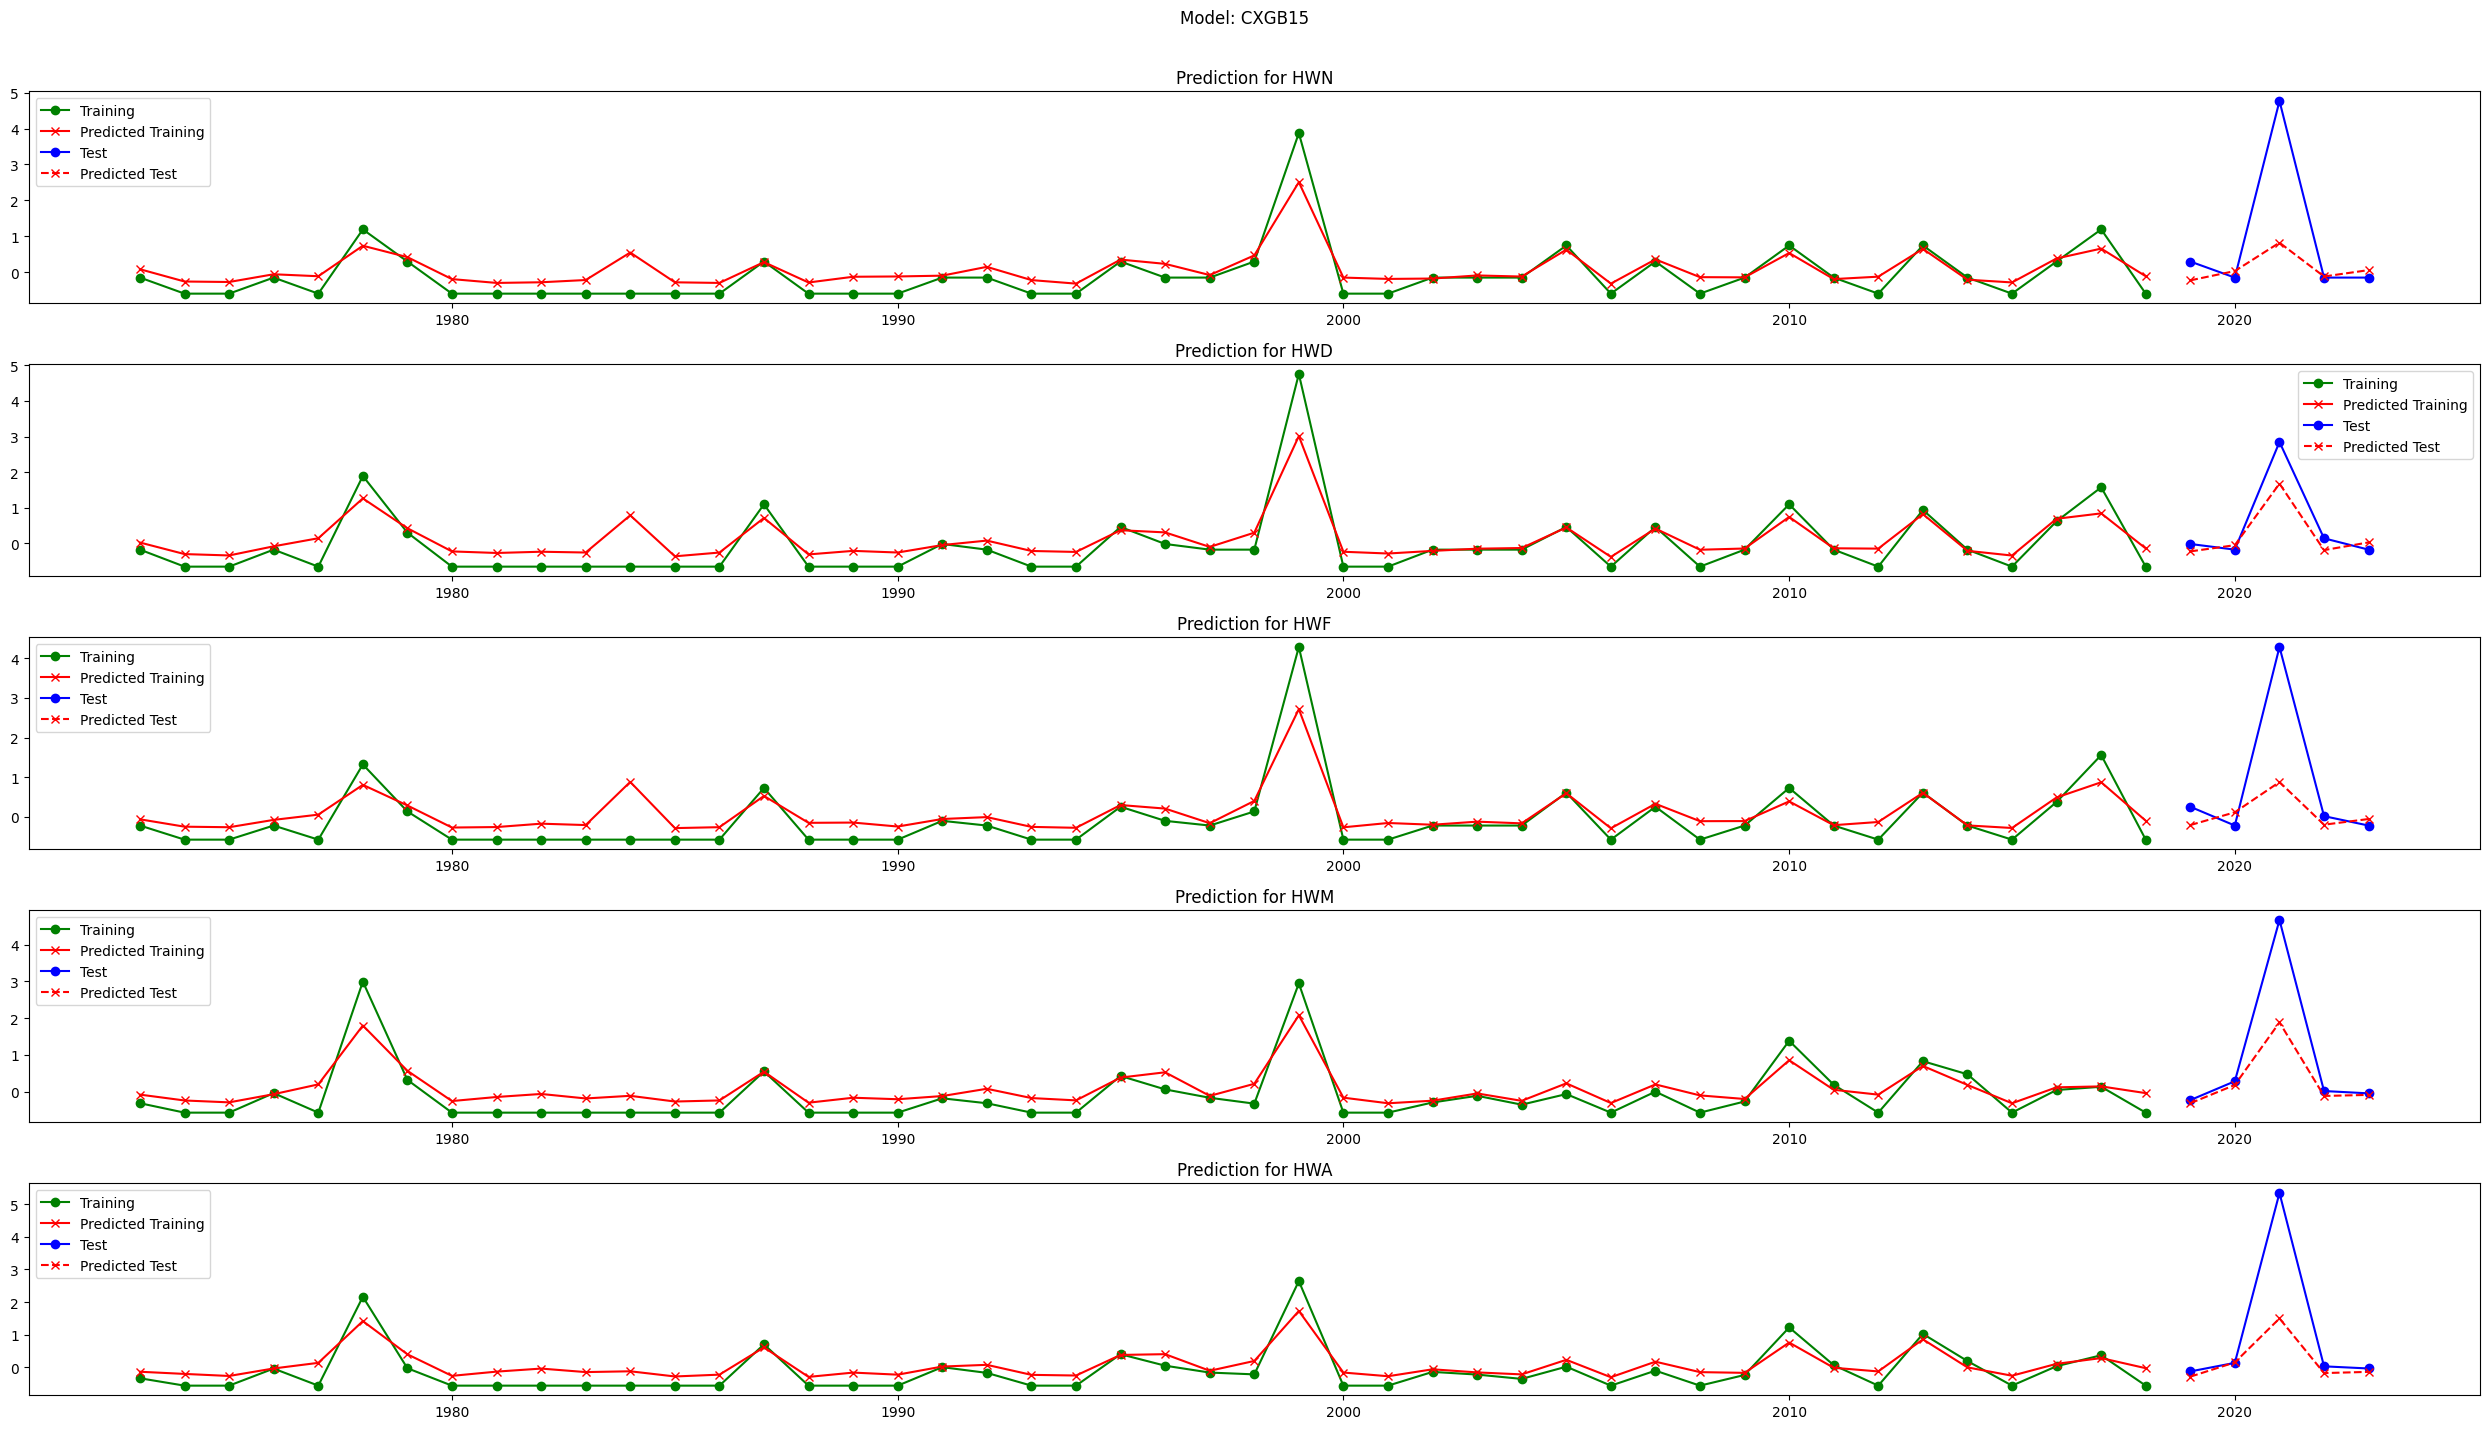

In [40]:
id = "ecf2577f"
season = 5
data = pd.read_parquet(f"data/climate_features/{region}/predictor_{id}_{season}.parquet")
# data = data.drop(columns=["HWF", "HWM", "HWD", "HWA"])
model = XGBCustomObjective(
    objective_func=sera_objective(piecewise_linear_phi_np(bounds, initial_weight=0.3)),
    random_state=42,
    n_estimators=15,
    learning_rate=0.1
)

pred = PredictionModel(data, season, indices, model, name_regressor="CXGB15")
y_train, y_pred_train = pred.train(5)
y_test, y_pred = pred.predict(5)
dates = pd.date_range(pd.to_datetime(f"1972-{season}"),periods=len(y_train) + len(y_test),freq=pd.offsets.YearBegin(1))
pred.plot_predictions(dates, 5, y_train, y_pred_train, y_test, y_pred)